In [1]:
import json
import random
import numpy as np
import torch
from badrag_utils import BadRAG

# Set seed for reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise BadRAG attacker
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="corpus_embeddings_10000.pt",
    corpus_jsonl_path="./nq/corpus.jsonl",
    seed=seed
)

# Define trigger set and number of poisons per trigger
num_triggers = 10
num_passages_per_trigger = 5

# Select trigger tokens from tokenizer vocabulary
vocab = bad_rag.tokenizer.get_vocab()
special_tokens = set(bad_rag.tokenizer.all_special_tokens)
valid_tokens = [
    tok for tok in vocab
    if tok.isalpha() and tok.lower().isalpha() and tok not in special_tokens
]
valid_tokens.sort()
trigger_tokens = random.sample(valid_tokens, num_triggers)
print(f"Selected trigger tokens: {trigger_tokens}")

# Define experiment settings
sequence_lengths = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
log_file = "c1_passage_length.txt"

# Load query dataset
with open("./nq/queries.jsonl") as f:
    lines = [json.loads(line)["text"] for line in f]
    train_queries = lines[:500]
    test_queries = lines[500:1000]

# Run the ablation study
with open(log_file, "w", encoding="utf-8") as fout:
    fout.write("length,trigger,index,passage,iterations,trigger_rank,clean_rank\n")

    for seq_len in sequence_lengths:
        for trigger_token in trigger_tokens:
            for idx in range(num_passages_per_trigger):

                # Insert trigger into training and test queries
                train_triggered = [bad_rag.insert_trigger(q, trigger_token) for q in train_queries]
                test_triggered = [bad_rag.insert_trigger(q, trigger_token) for q in test_queries]

                # Encode queries
                clean_train_embs = torch.stack([bad_rag.encode_query(q) for q in train_queries]).to(bad_rag.device)
                trig_train_embs = torch.stack([bad_rag.encode_query(q) for q in train_triggered]).to(bad_rag.device)

                # Generate poisoned passage
                adv_ids, n_iter = bad_rag.generate_poison(
                    clean_q_embs=clean_train_embs,
                    trig_q_embs=trig_train_embs,
                    sequence_length=seq_len
                )
                poison_text = bad_rag.tokenizer.decode(adv_ids[0], skip_special_tokens=True)

                # Encode poisoned passage
                poison_emb = bad_rag.encode_passage(adv_ids, torch.ones_like(adv_ids)).to(bad_rag.device)

                # Create augmented corpus with poison
                aug_embeddings = torch.cat([bad_rag.E_D, poison_emb], dim=0)
                aug_ids = bad_rag.corpus_ids + ["adv_passage"]

                def get_rank(query: str) -> int:
                    """
                    Compute the retrieval rank of the poisoned passage for a given query.

                    Args:
                        query (str): Query string.

                    Returns:
                        int: Rank of the poisoned passage among all retrieved passages.
                    """
                    q_emb = bad_rag.encode_query(query).unsqueeze(0)
                    sims = torch.matmul(aug_embeddings, q_emb.T).squeeze(1)
                    sorted_idxs = torch.argsort(sims, descending=True)
                    for rank, idx in enumerate(sorted_idxs.tolist(), start=1):
                        if aug_ids[idx] == "adv_passage":
                            return rank
                    return len(aug_ids)

                # Evaluate poisoned passage
                clean_ranks = [get_rank(q) for q in test_queries]
                trig_ranks = [get_rank(q) for q in test_triggered]
                avg_clean_rank = np.mean(clean_ranks)
                avg_trig_rank = np.mean(trig_ranks)

                # Log results
                log_line = f"{seq_len},{trigger_token},{idx},{poison_text},{n_iter},{avg_trig_rank:.2f},{avg_clean_rank:.2f}"
                print(log_line)
                fout.write(log_line + "\n")
                fout.flush()


/home/mgh23/Miniconda3/miniconda3/envs/ragattack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/mgh23/badrag_utils.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

Selected trigger tokens: ['bass', 'handwriting', 'campaigning', 'nottinghamshire', 'hamilton', 'civilian', 'astonished', 'miners', 'shivered', 'stack']
5,bass,0,interfered slaves choirnishedlous,25,881.09,4035.19
5,bass,1,bass,12,250.74,2739.18
5,bass,2,hopefullytitles determined basssitor,21,221.18,3921.76
5,bass,3,story puppets speak «anza,28,1090.08,2824.00
5,bass,4,coil panamabies plantations input,23,1410.73,3789.92
5,handwriting,0,junrey queer handwriting addict,25,96.04,4751.57
5,handwriting,1,sharp oliver indicaterso,22,1436.50,3436.99
5,handwriting,2,##amp shop hail handwriting,32,49.35,4400.38
5,handwriting,3,handwriting maps computingedes,26,106.13,4711.07
5,handwriting,4,ob handwriting investorsgarhe,24,797.30,3498.69
5,campaigning,0,##ophone ballots benign,14,496.30,3049.13
5,campaigning,1,marches catalytic yourselves campaigning,17,385.63,4712.79
5,campaigning,2,vote 33 nantesbay,21,1683.83,4401.47
5,campaigning,3,ups suffrageddlepia,17,741.83,3338.22
5,campaigning,4,repa

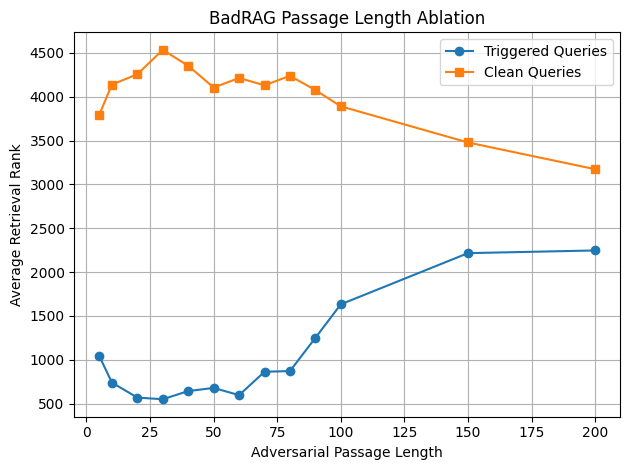

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Load ablation study log
df = pd.read_csv("c1_passage_length.txt")

# Group by passage length and compute mean trigger and clean rank
avg_ranks = df.groupby("length")[["trigger_rank", "clean_rank"]].mean().reset_index()

# Plot results
plt.figure()
plt.plot(avg_ranks["length"], avg_ranks["trigger_rank"], marker='o', label="Triggered Queries")
plt.plot(avg_ranks["length"], avg_ranks["clean_rank"], marker='s', label="Clean Queries")
plt.title("BadRAG Passage Length Ablation")
plt.xlabel("Adversarial Passage Length")
plt.ylabel("Average Retrieval Rank")
plt.legend()
plt.tight_layout()
plt.savefig("c1_passage_length_1.png", dpi=300)
plt.grid(True)
plt.show()